## Single decision tree

In [1]:
from import_data import * # makes df_train_with_labels, and df_test_last
from constants import *
from CRPS import *
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

# set up parameters based on A4 paper
plt.rcParams.update({
    "savefig.dpi": 300,
    "font.size": 10,  # Font size for text (like in the report)
    # "axes.labelsize": 8,  # Font size for x-axis labels
})


In [ ]:
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.tree import DecisionTreeRegressor

def search_best_params():
    """
    Function to search for the best hyperparameters for DecisionTreeRegressor
    This function takes a lot of time to run
    """
    
    print(f"Starting GridSearchCV with DecisionTreeRegressor to find the best hyperparameters.")
    shuffled_cv = GroupShuffleSplit(
            n_splits = 5,
            test_size = 2/100, # 2 of the 100 engines
            random_state = 42
    )
    
    param_grid = {
        "max_depth":       [5, 8, 10, 15, 30, None],
        "min_samples_split": [2, 3, 4],
        "min_samples_leaf": [1, 2, 3],
        "max_features":    [None, 'sqrt', 'log2'],
        "criterion":       ["squared_error"],
    }
    
    print(f"Using the following hyperparameter grid for DecisionTreeRegressor:\n{param_grid}")
    
    # Base DecisionTreeRegressor
    DTR_search = DecisionTreeRegressor(
        random_state=42,
    )
    
    # GridSearchCV to find the best hyperparameters
    gscv = GridSearchCV(
            estimator=DTR_search,
            param_grid=param_grid,
            cv=shuffled_cv,
            scoring=["neg_root_mean_squared_error","neg_mean_absolute_error", "r2"],
            refit="neg_root_mean_squared_error",
            n_jobs=6,         #parallel tasks
            verbose=2,
    )

    gscv.fit(df_train_with_labels[sensors_of_interest],
            df_train_with_labels.RUL,
            groups=df_train_with_labels["engine"] # Keep engines together in the same fold
    )
    
    print("Best params :", gscv.best_params_)
    print("Val-set RMSE:", -gscv.best_score_)
    print("Val-set MAE:", -gscv.cv_results_['mean_test_neg_mean_absolute_error'][gscv.best_index_])
    print("Val-set R2:", gscv.cv_results_['mean_test_r2'][gscv.best_index_])
    
    best_dtr= gscv.best_estimator_
    return best_dtr, gscv.best_params_

# _, best_params_ = search_best_params() # Uncomment to run the search for best parameters

# already found best parameters
best_params_ = {'criterion': 'squared_error',
 'max_depth': 8,
 'max_features': None,
 'min_samples_leaf': 3,
 'min_samples_split': 2}

Starting GridSearchCV with DecisionTreeRegressor to find the best hyperparameters.
Using the following hyperparameter grid for DecisionTreeRegressor:
{'max_depth': [5, 8, 10, 15, 30, None], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 3], 'max_features': [None, 'sqrt', 'log2'], 'criterion': ['squared_error']}
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best params : {'criterion': 'squared_error', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2}
Val-set RMSE: 17.893278374749293
Val-set MAE: 12.966801678058971
Val-set R2: 0.8047364909590653


In [6]:
best_params_

{'criterion': 'squared_error',
 'max_depth': 8,
 'max_features': None,
 'min_samples_leaf': 3,
 'min_samples_split': 2}

## Test with best parameters

In [7]:
import sklearn.metrics as met

DTR_best = DecisionTreeRegressor(**best_params_, random_state=42)
DTR_best.fit(df_train_with_labels[sensors_of_interest], df_train_with_labels.RUL)

DTR_predictions = DTR_best.predict(df_test_last[sensors_of_interest])

print(f"Predictions on test set: {DTR_predictions[:10].astype(np.int32)} ...")  # Print first 10 predictions

RMSE_test = met.root_mean_squared_error(test_labels, DTR_predictions.astype(np.int32))
MAE_test = met.mean_absolute_error(test_labels, DTR_predictions)
R2_SCORE_ = met.r2_score(test_labels, DTR_predictions)
CRPS_ = CRPS({0:test_labels[0].to_numpy().flatten()}, {0:DTR_predictions.copy()}) # messes with the order of the array. Only pass copies

print(f"RMSE on test set: {RMSE_test:.2f}")
print(f"MAE on test set: {MAE_test:.2f}")
print(f"R2 score on test set: {R2_SCORE_:.2f}")
print(f"CRPS on test set: {CRPS_}")

Predictions on test set: [121 115  60 108 116 108 104 107 108 108] ...
RMSE on test set: 18.88
MAE on test set: 14.15
R2 score on test set: 0.78
CRPS on test set: (np.float64(27.021605115467263), np.float64(32.868706316054535))


## Visual representation of the accuracy of the predictions

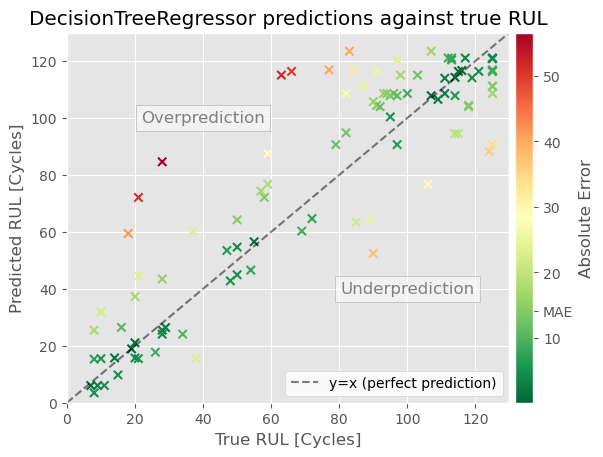

In [8]:
fig, ax = plt.subplots(figsize=fig_size(1, 0.5))

ax.scatter(test_labels, DTR_predictions, alpha=1, marker='x', c=np.abs(test_labels.to_numpy().flatten() - DTR_predictions), cmap='RdYlGn_r')
ax.plot([0, 130], [0, 130], color='black', alpha=0.5, linestyle='--', label='y=x (perfect prediction)')
ax.set_xlabel("True RUL [Cycles]")
ax.set_ylabel("Predicted RUL [Cycles]")
ax.set_title("DecisionTreeRegressor predictions against true RUL")

# add overprediction and underprediction regions
ax.text(40, 100, "Overprediction", fontsize=12, color='grey', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='grey'))
ax.text(100, 40, "Underprediction", fontsize=12, color='grey', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='grey'))
ax.set_ylim(0, 130)
ax.set_xlim(0, 130)

# colorbar
clb = plt.colorbar(ax.collections[0], label='Absolute Error', pad=0.01)
clb.ax.set_yticks([*clb.ax.get_yticks()[1:-1], MAE_test], labels=[*clb.ax.get_yticklabels()[1:-1], f'MAE'])


ax.legend(facecolor='white', loc='lower right')
plt.tight_layout()
plt.savefig("Output/singletree_predictions_vs_true_RUL.png", bbox_inches='tight')
plt.show()